# Análisis Exploratorio de Alquileres de Bicicletas en San Francisco

Para comenzar el análisis exploratorio importamos las bibliotecas a utilizar.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Comenzando con trips.csv

Leemos el archivo de viajes, avisando qué columnas son fechas (el formato será inferido para un parseo más rápido). También vemos un registro de ejemplo y los tipos de sus columnas.

In [2]:
viajes = pd.read_csv("dataset/trip.csv", 
                     parse_dates=["start_date", "end_date"], infer_datetime_format=True,
                     dtype={"subscription_type":"category"})
viajes.head(1)

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127


In [4]:
viajes.dtypes

id                             int64
duration                       int64
start_date            datetime64[ns]
start_station_name            object
start_station_id               int64
end_date              datetime64[ns]
end_station_name              object
end_station_id                 int64
bike_id                        int64
subscription_type           category
zip_code                      object
dtype: object

## Análisis General de Duración

El objetivo final del trabajo será el de predecir la duración de un viaje en base a todos los otros datos. Por lo cual conviene empezar por ver qué clase de datos tenemos en duración.

Primero máximos y mínimos:

In [ ]:
viajes.duration.sort_values().head(5)

Se ve que los mínimos son todos de 60 segundos. Podemos pensar que es la mínima cantidad de tiempo registrado en un préstamo.

Más adelante haremos un análisis de estos casos.

In [ ]:
viajes.duration.sort_values().tail(10)/(3600*24)

En cuanto a los máximos, los medimos en días para obtener un número más significativo. Varios andan en un poco más de una semana, varios en un par y un outlier de cerca de 6 meses.trips.

In [ ]:
cuantilDuracion = viajes.duration.quantile(0.995)
cuantilDuracion /3600

Si quitamos el cuantil de los 0.5% valores más altos (los registros superiores a un poco menos de 6 horas), podemos hacer el siguiente gráfico:

In [ ]:
viajes_sin_outliers = viajes[viajes.duration < cuantilDuracion]

In [ ]:
viajes_sin_outliers.duration.apply(lambda x: x/3600).plot.box();
plt.title("Duraciones de los recorridos.")
plt.show()

Se ve que aunque la mayor parte de los valores están concentrados en duraciones cortas (menores a media hora), aún quitando ese cuantil superior hay valores muy lejanos a la media, cercanos a las 6 horas.

Esto puede verse en la diferencia entre los valores de media y mediana:

In [ ]:
print("Media:   " + str(viajes_sin_outliers.duration.mean()))
print("Mediana: " + str(viajes_sin_outliers.duration.median()))

Para analizar mejor la distribución, realizamos un histograma.

In [ ]:
# Distribucion de la duracion de los viajes en cantidad de minutos
viajes.duration.apply(lambda d: d/100).hist(bins=range(1,100));
plt.show()

In [ ]:
# Haciendo foco en los de menos de 20 minutos
viajes.duration.hist(bins=range(1,1200,10));
plt.show()

Los valores más frecuentes están rondando los 400 segundos (casi 7 minutos).

## Días de la Semana

Vamos a ver si existe una diferencia sustancial en los alquileres según los días de la semana.

### Cantidad

Veremos la cantidad de apariciones según comienzo y fin del viaje, y normalizaremos por la cantidad de días, así tendremos la cantidad promedio de viajes por día. 

Para facilitar el uso de días, de aquí en adelante usaremos una variable categórica "week_day".

In [5]:
# Agrego el week_day
dias_ordenados = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
viajes["week_day"] = pd.Categorical(viajes.start_date.dt.weekday_name, categories=dias_ordenados)

Ahora contamos la aparición de cada día.

In [ ]:
# Cantidad de días distintos
fechasDistintas = pd.DataFrame({"fecha": viajes.start_date.dt.date, "week_day": viajes.week_day})
cantDias = fechasDistintas.groupby(["week_day","fecha"]).agg(lambda x:1).reset_index().week_day.value_counts()
# Arreglo del índice categórico.
cantDias.index = pd.Categorical(cantDias.index, categories=dias_ordenados)
cantDias = cantDias.sort_index()
cantDias

In [ ]:
totalDias = cantDias.sum()
totalDias

Volviendo al objetivo: vamos a ver la distribución de la cantidad de alquileres según el día, y normalizamos por la cantidad de días.

In [ ]:
(viajes.groupby("week_day").size()/cantDias).plot(kind='bar',figsize=(12,8));
plt.title("Cantidad de alquileres promedio segun dia de la semana")
plt.xlabel("Dia de la semana")
plt.ylabel("Cantidad de alquileres")
plt.show()

Podemos ver que en promedio, durante el fin de semana baja sustancialmente la cantidad de alquileres. Con este dato en mente, separaremos muchas mediciones en días de semana y en fines de semana. Para facilitar esto agregamos una columna que explicita si un registro es del fin de semana o de día laboral.

In [3]:
viajes["finde"] = viajes.start_date.dt.dayofweek >= 5

### Duración - Distribuciones

Según el día de semana, veremos también las diferencias en duración. Primero vemos las distribuciones.

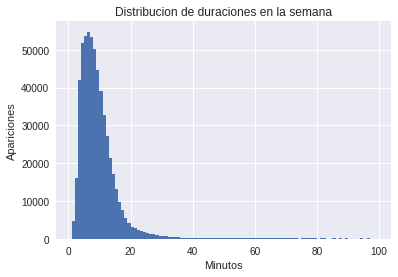

In [14]:
# Días de semana(en minutos)
viajes.loc[~viajes.finde,"duration"].apply(lambda x: x/60).hist(bins=range(1,100));
plt.title("Distribucion de duraciones en la semana")
plt.xlabel("Minutos")
plt.ylabel("Apariciones")
plt.show()

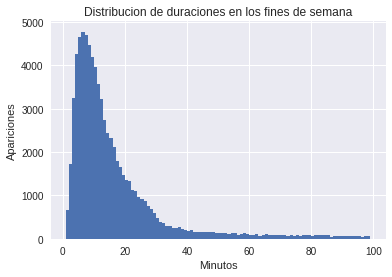

In [6]:
# Fines de semana (en minutos)
viajes.loc[viajes.finde,"duration"].apply(lambda x: x/60).hist(bins=range(1,100));
plt.title("Distribucion de duraciones en los fines de semana")
plt.xlabel("Minutos")
plt.ylabel("Apariciones")
plt.show()

Si bien la diferencia no es tan pronunciada, se ve que para los fines de semana hay un aumento sustancial de viajes largos.

## Distribuciones por hora
El mismo análisis anterior puede repetirse diferenciando a su vez por hora. Agregamos una columna con la hora.

In [20]:
viajes["hour"] = viajes.start_date.dt.hour

### Cantidad de Alquileres

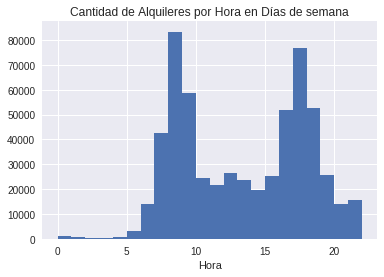

In [21]:
# Días de semana
viajes.loc[~viajes.finde, "hour"].hist(bins=range(0,23));
plt.title("Cantidad de Alquileres por Hora en Días de semana")
plt.xlabel("Hora")
plt.show()

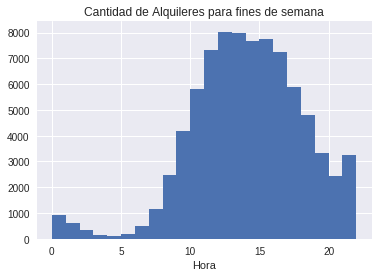

In [22]:
# Fines de semana
viajes.loc[viajes.finde, "hour"].hist(bins=range(0,23));
plt.title("Cantidad de Alquileres para fines de semana")
plt.xlabel("Hora")
plt.show()

El comportamiento en cantidad de alquileres es muy distinto. En días de semana se ven picos claros en las horas de ingreso y salida del trabajo (8hs y 17hs), mientras que en los fines de semana hay un crecimiento menos acentuado hacia el mediodía y la tarde temprana.

### Duración

Vemos si este comportamiento coincide en la duración. Uno podría esperar que a mayor cantidad de alquileres habrá más tráfico y por lo tanto los viajes durarán más.

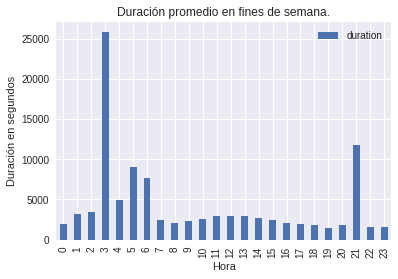

In [28]:
viajes.loc[viajes.finde,['duration', 'hour']].groupby('hour').mean().plot.bar();
plt.title("Duración promedio en fines de semana.")
plt.xlabel("Hora")
plt.ylabel("Duración en segundos")
plt.show()

Caben dos observaciones importantes:

1. Los picos de las 3 de la mañana y las 21 se dan por la poca cantidad de registros a esas horas.
2. Entre las 7 y las 20 el comportamiento de las duraciones aumenta de forma similar a la cantidad de alquileres, estableciendo una posible relación para futuras predicciones.

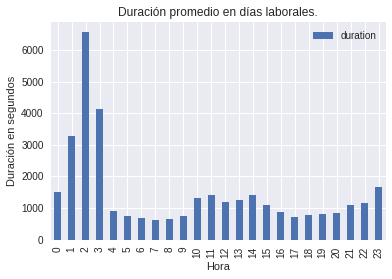

In [31]:
viajes.loc[~viajes.finde,['duration', 'hour']].groupby('hour').mean().plot.bar();
plt.title("Duración promedio en días laborales.")
plt.xlabel("Hora")
plt.ylabel("Duración en segundos")
plt.show()

Aquí, si bien se repite el problema del pico de duraciones a las 2-3 de la mañana, es interesante observar que el comportamiento en duraciones es más parecido al de fin de semana que al de cantidad de alquileres en la semana.

Teniendo en cuenta los picos a las 3 de la mañana, lo más probable es que convenga tener distintos modelos para la noche y madrugada que para el día.

## Recorridos

Otra variable que podría influir notoriamente en la duración es el par `start_station`-`end_station`. Si una persona viaja entre las mismas dos estaciones en días distintas, es probable que la duración del viaje sea muy similar. 

El primer problema que enfrentamos es que los ids de las estaciones son columnas categóricas (que un id sea mayor a otro no significa nada en si mismo, por lo que sería un error tratarlos como número entero). Por este motivo, lo que haremos es calcular en cambio la _distancia_ entre las estaciones de salida y llegada.

Para construir las distancias utilizaremos el archivo `station.csv`, que contiene los datos de cada una.

In [32]:
estaciones = pd.read_csv("dataset/station.csv")

In [33]:
#armo un diccionario de distancias

ids = estaciones.id
stm = estaciones[["id", "lat", "long"]]

distancias = {}
for id1 in ids:
    x = stm.loc[estaciones.id == id1,["lat","long"]].values
    x = (x[0][0],x[0][1])
    for id2 in ids:
        y = stm.loc[estaciones.id == id2,["lat","long"]].values
        y = (y[0][0],y[0][1])
        # Distancia Manhattan
        distancias[(id1,id2)] = abs(y[0]-x[0]) + abs(y[1] - x[1])

In [34]:
def d(id1,id2):
    return distancias[(id1,id2)]

In [35]:
viajes["dist"] = viajes.apply(lambda x: d(x.start_station_id, x.end_station_id), axis=1)

In [36]:
# Radio de la tierra en KM
from math import pi
from numpy import sin

R = 6378.137
# Conversor de grados a radianes
conv = pi/180

# Conversión a km de toda la columna.
viajes["distkm"] = R*sin(conv*viajes.dist)

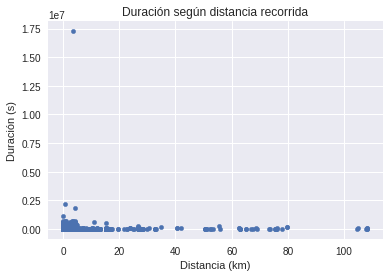

In [39]:
viajes[["distkm","duration"]].plot.scatter(x="distkm",y="duration");
plt.title("Duración según distancia recorrida")
plt.xlabel("Distancia (km)")
plt.ylabel("Duración (s)")
plt.show()

Lo que notamos inmediatamente es que los outliers de duración arruinan cualquier relación posible, dada su magnitud.

Además, resulta interesante que hay viajes de más de 100km, lo cual se comentará más adelante.

Para el problema de los outliers, sin hilar fino, quitamos el 10% de viajes más largos.

In [40]:
viajesCortos = viajes[viajes.duration < viajes.duration.quantile(0.9)]
viajes.duration.quantile(0.9)/60

19.216666666666665

Esto nos deja los viajes de 19 minutos o menos, que aunque son notoriamente cortos, es importante notar que son el 90% de los viajes.

In [46]:
viajesCortos.distkm.describe()

count    602877.000000
mean          1.873837
std           0.854986
min           0.000000
25%           1.239654
50%           1.803821
75%           2.266131
max          52.833852
Name: distkm, dtype: float64

También es importante notar que dentro de los viajes cortos también hay algunos outliers en distancias (un caso que en menos de 20 minutos recorre 52km, muy poco probable en bicicleta). Ploteamos entre 0 y 9 km.

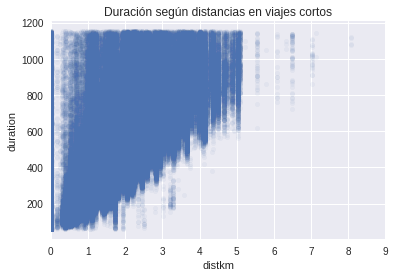

In [47]:
viajesCortos[["distkm","duration"]].plot.scatter(x="distkm",y="duration", alpha=0.05);
plt.title("Duración según distancias en viajes cortos")
plt.xlim([0,9])
plt.show()

Para estos viajes cortos puede observarse:

1. La cota inferior de la duración es notoriamente lineal respecto de la distancia recorrida. Esto es esperable, dado que lo mínimo que tarda en recorrerse un camino dependerá mucho de la distancia.
2. La cota superior no es clara, pero parece disminuir con la distancia también. 
3. A partir de 5 km hay un corte abrupto de viajes, probablemente relacionado con el tamaño de la ciudad y del área donde suelen moverse los viajantes.

Vamos a ver si logramos ver una cota superior más clara:

In [52]:
# Viajes de menos de 50 minutos.
viajesMedianos = viajes[viajes.duration < 3000]

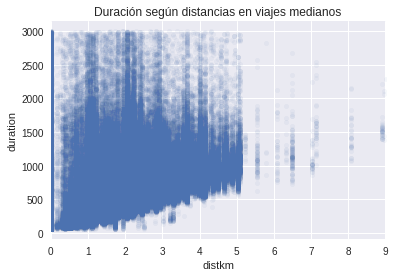

In [53]:
viajesMedianos[["distkm","duration"]].plot.scatter(x="distkm",y="duration", alpha=0.05);
plt.title("Duración según distancias en viajes medianos")
plt.xlim([0,9])
plt.show()

### Correlación General entre las variables

Efectuamos un heatmap con la matriz de correlación del dataframe `viajes` con las columnas que fuimos agregando.

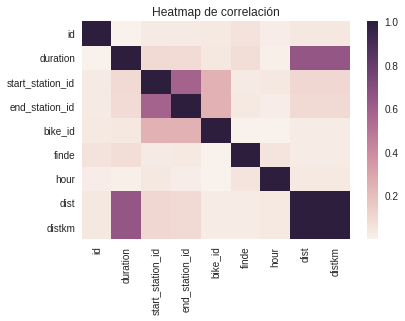

In [51]:
sns.heatmap(viajesCortos.corr().abs());
plt.title("Heatmap de correlación")
plt.show()

Puede verse una notoria correlación con la duración, tal como se había notado antes.

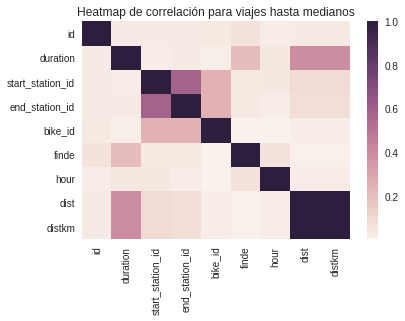

In [54]:
sns.heatmap(viajesMedianos.corr().abs());
plt.title("Heatmap de correlación para viajes hasta medianos")
plt.show()

En este caso se ve que se reduce la correlación entre duración y distancia (aunque su cota superior se vea un poco mejor). Sin embargo, aumenta notoriamente la correlación con estar o no en un fin de semana. 

Estas diferencias resaltan la necesidad de separar los viajes según su distancia en distintos grupos, y probablemente separar los modelos para cada uno.

## Viajes Largos

Un primer análisis erróneo del archivo de climas partió de la hipótesis de que todas las estaciones eran cercanas y por lo tanto podía tomarse un único zip_code. 